In [1]:
import pandas as pd
import numpy as np
import os
import getpass
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def list_files(files):
    """Accepts a list and returns a dictionary of each item in list with a numbered index (key) starting at 1"""

    dir_list = {0:'Exit'}
    file_count = 0
    for file in files:
        file_count +=1
        dir_list[file_count] = file  # assign a number to each item in the list starting with 1 
    return dir_list  # returns the dictionary of items in the list

def print_dict(dict_items):
    """Prints the key:value pairing in a dictionary"""

    for key, value in dict_items.items():
        print(key, ":", value)

def check_dict(dict_to_check, choice):
    """Checks if the input choice is a key in the provided dictionary
        and returns 'valid' if true, 'invalid' if false"""

    if choice in dict_to_check:
        key_exists = "valid"
    else:
        key_exists = "invalid"

    return key_exists

def error_message(invalid_choice):
    print(f"Your input of '{invalid_choice}' is not a valid choice.")

def validate_int(user_input):
    """Checks if user input is an int. If not returns 'is_not_int'"""

    try:
        int(user_choice)
    except ValueError:
        print(f"'{user_choice}' is not an integer.")
        return "is_not_int"

def file_message():
    message1 = {1:'Great choice', 2:'Yes', 3:'Right away', 4:'Beep Boop Boop'}
    message2 = {1:'Fetching', 2:'Opening', 3:'Gathering'}

    mess1 = message1[random.randint(1,4)]
    mess2 = message2[random.randint(1,3)]
    return (mess1,mess2)

def target_test_keys(keys): 
    """Accepts a list of lists and returns a list of the first value from each list"""
    
    spec_keys = []
    for i in range(len(keys)):
        spec_keys.append(keys[i][0])
    return spec_keys

def get_target_columns(col_list, spec_keys):
    target_columns = []
    for i in range(len(col_list)):
        if col_list[i] in spec_keys:
            target_columns.append(col_list[i])
    return target_columns

def create_spec_dict(spec_arr):
    new_dict = {}
    new_list = []
    for i in range(len(spec_arr)):
        new_list = [spec_arr[i][1],spec_arr[i][2]]
        new_dict[spec_arr[i][0]] = new_list
    return new_dict

def combine_limits(targ_col,prod_spec_dict):  # This is making a big assumption that the lower limits are listed before upper limits in specifications file
    prod_ll = []
    prod_ul = []
    prod_ll_dict = {}
    prod_ul_dict = {}
    for i in range(len(targ_col)):
        key = targ_col[i]
        prod_ll.append(prod_spec_dict[key][0])
        prod_ul.append(prod_spec_dict[key][1])
        
    prod_ll_dict['lower_limits'] = prod_ll
    prod_ul_dict['upper_limits'] = prod_ul
    return {**prod_ll_dict, **prod_ul_dict}

def create_histplot(test_key, limits, df, prod_name):
    low_spec = limits[0]
    upp_spec = limits[1]

    # plt.figure(figsize=(6,4))
    # sns.histplot(data=df[test_key], binwidth=0.2, kde=True, color='green')
    # plt.axvline(low_spec, 0, 1, color='red', label="LSL")  # lower limit reference line
    # plt.axvline(upp_spec, 0, 1, color='red', label="USL")  # upper limit reference line
    # plt.title(prod_name)
    # plt.legend()
    # plt.savefig(f"graph_output/{prod_name}_{test_key}.png", facecolor='w', edgecolor='w', orientation='portrait', transparent=False)
    print(f"{prod_name}_{test_key}.png was successfully saved to the graph_output folder!")
    # plt.show()


0 : Exit
1 : BK012.csv
2 : BL008.csv
3 : BR040.csv
4 : GR014.csv
5 : YL001.csv
6 : YL036.csv
7 : YL056.csv
Yes! Fetching BL008.csv now...
158 of the 268 (59.0%) BL008 batches are within the BL008 specifications.

0 : Exit
1 : BK012.csv
2 : BL008.csv
3 : BR040.csv
4 : GR014.csv
5 : YL001.csv
6 : YL036.csv
7 : YL056.csv
Beep Boop Boop! Opening BR040.csv now...
159 of the 212 (75.0%) BR040 batches are within the BR040 specifications.

BR040_TDB.png was successfully saved to the graph_output folder!
BR040_STR.png was successfully saved to the graph_output folder!
Your input of '10' is not a valid choice.
0 : Exit
1 : MDL
2 : MDA
3 : MDB
4 : TDL
5 : TDA
6 : TDB
7 : STR
8 : 325MSH
BR040_MDB.png was successfully saved to the graph_output folder!
0 : Exit
1 : BK012.csv
2 : BL008.csv
3 : BR040.csv
4 : GR014.csv
5 : YL001.csv
6 : YL036.csv
7 : YL056.csv


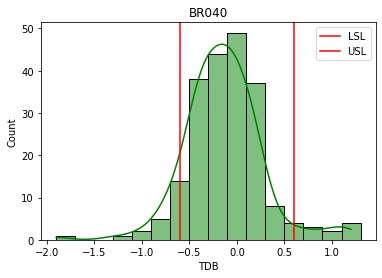

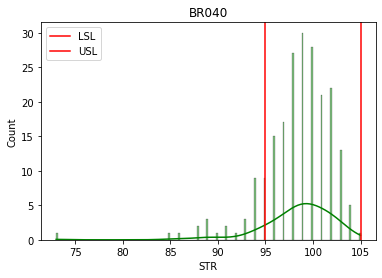

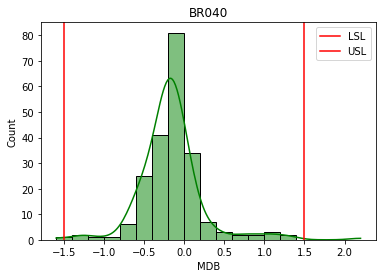

In [15]:
loop_main = "Y"
while loop_main == "Y":
    dirs = sorted(os.listdir('data'))
    dir_list = list_files(dirs)  # returned dict of files in directory

    print_dict(dir_list)
    user_choice = input('Enter the number next to the file to open. (0 to exit): ')

    int_check = validate_int(user_choice)
    if int_check == "is_not_int":
        validate_choice = "invalid"
    else:
        validate_choice = check_dict(dir_list, int(user_choice)) # check to see if user input is a key in the dictionary

    while validate_choice == "invalid":
        error_message(user_choice)
        print_dict(dir_list)
        user_choice = input('Enter the number next to the file to open. (0 to exit): ')
        int_check = validate_int(user_choice)
        if int_check == "is_not_int":
            validate_choice = "invalid"
        else:
            validate_choice = check_dict(dir_list, int(user_choice)) # check to see if user input is a key in the dictionary

        if int(user_choice) == 0:
            break

    if int(user_choice) == 0:  # break the main loop
            break

    if int(user_choice) != 0:
        selected_file = dir_list[int(user_choice)]
        fill_messages = file_message()
        print(f"{fill_messages[0]}! {fill_messages[1]} {selected_file} now...")
        time.sleep(2)  # pause execution for message
        df_all_specs = pd.read_csv('specifications.csv').set_index('product')  # read all product specifications into a df
        file_to_open = 'data/' + selected_file
        df = pd.read_csv(file_to_open)
        prod = os.path.splitext(selected_file)[0]  # separate filename from extension 
        df_prod_specs = df_all_specs.iloc[lambda x: x.index == prod]  # filter specifications by product name from the selected file
        prod_specs_arr = df_prod_specs.values  # create numpy array from product specifications df
        prod_target_keys = target_test_keys(df_prod_specs.values)  # creates a list of product test keys that are in specifications file
        target_columns = get_target_columns(df.columns, prod_target_keys)  # creates a list of column name values, from the selected file,  that match values in prod_target_keys list
        prod_spec_dict = create_spec_dict(prod_specs_arr)  # creates a dict of prod test keys {key = test key: value = [lower limit value, upper limit value]}
        prod_limits_dict = combine_limits(target_columns,prod_spec_dict) # create dict of all product limits {key = upper_limits or lower_limits: value = [all test key limits]}

        # evaluate results in product file vs lower and upper limits in specifications file
        test_values = df[target_columns].to_numpy(dtype=float)
        lower_limits = np.array(prod_limits_dict['lower_limits'])
        upper_limits = np.array(prod_limits_dict['upper_limits'])
        is_below_ll = (np.less(test_values,lower_limits))  # array displays true if test value below lower spec limit
        is_above_ul = (np.greater(test_values,upper_limits))  # array displays true if test value above upper spec limit
        combined_arr = np.add(is_below_ll, is_above_ul)  # adds the two boolean arrays 
        # create dataframe of the reverse boolean numpy array (using ~)
        combined_df_in_spec = ~pd.DataFrame(data=combined_arr[0:,0:],
                                index=(df['Lot'].values),  #  assuming "Lot" is a column name in selected product file
                                columns=target_columns)

        combined_df_in_spec['is_in_spec'] = combined_df_in_spec.prod(1)  # create column in df to show if all test results for a lot are within specifications
        total_df_rows = combined_df_in_spec.shape[0]
        total_in_spec_rows = combined_df_in_spec['is_in_spec'].sum()
        percent_good = "{:.1%}".format(total_in_spec_rows/total_df_rows)
        # rebuild specifications in dataframe to test keys show up in a predictable order
        spec_df = pd.DataFrame(data=(lower_limits,upper_limits),
                                index=['Lower Limits', 'Upper Limits'],
                                columns=target_columns)

        # print()  # whitespace
        # print('Overview of file contents:')
        # print(df.head(5))
        # print()
        # print(f"The specifications for {prod} are:")
        # print(spec_df)
        # print()
        print(f'{int(total_in_spec_rows)} of the {total_df_rows} ({percent_good}) {prod} batches are within the {prod} specifications.')
        print()
    
        # chart display
        test_key_opt_dict = list_files(target_columns)
        #print_dict(test_key_opt_dict)
        user_choice = input('To create a histogram of test results enter the number of the corresponding test key above. (0 to exit): ')
        loop_graph = "Y"
        while loop_graph == "Y".upper():
            int_check = validate_int(user_choice)

            if int(user_choice) != 0:
                if int_check == "is_not_int":
                    validate_choice = "invalid"
            
                try:
                    validate_choice = check_dict(prod_spec_dict, test_key_opt_dict[int(user_choice)]) # check to see if user input is a key in the dictionary
                except KeyError:
                    validate_choice = "invalid"
                    
                while validate_choice == "invalid":
                    error_message(user_choice)
                    print_dict(test_key_opt_dict)
                    user_choice = input('To see a histogram of test results enter the number of the corresponding test key. (0 to exit): ')
                    if int(user_choice) != 0:
                        int_check = validate_int(user_choice)
                        if int_check == "is_not_int":
                            validate_choice = "invalid"
                        
                        try:
                            validate_choice = check_dict(prod_spec_dict, test_key_opt_dict[int(user_choice)]) # check to see if user input is a key in the dictionary
                        except KeyError:
                            validate_choice = "invalid"

                    if int(user_choice) == 0:
                        break

            if int(user_choice) != 0:
                selected_test_key = test_key_opt_dict[int(user_choice)]
                test_key_limits = prod_spec_dict[selected_test_key]
                create_histplot(selected_test_key, test_key_limits, df, prod)

            if int(user_choice) == 0:
                loop_graph = "N"
            else:
                user_choice = input("To create another histogram enter another number. (0 to exit): ")
                loop_graph = "Y"

        loop_main = input("Would you like to open another file? (Enter Y to continue or any other key to exit): ").upper()


In [ ]:
# Super easy no error path

dirs = sorted(os.listdir('data'))
dir_list = list_files(dirs)  # returned dict of files in directory

user_choice = 7

if int(user_choice) != 0:
    selected_file = dir_list[int(user_choice)]
    fill_messages = file_message()
    print(f"{fill_messages[0]}! {fill_messages[1]} {selected_file} now...")
    time.sleep(2)  # pause execution for message
    df_all_specs = pd.read_csv('specifications.csv').set_index('product')  # read all product specifications into a df
    file_to_open = 'data/' + selected_file
    df = pd.read_csv(file_to_open)
    prod = os.path.splitext(selected_file)[0]  # separate filename from extension 
    df_prod_specs = df_all_specs.iloc[lambda x: x.index == prod]  # filter specifications by product name from the selected file
    prod_specs_arr = df_prod_specs.values  # create numpy array from product specifications df
    prod_target_keys = target_test_keys(df_prod_specs.values)  # creates a list of product test keys that are in specifications file
    target_columns = get_target_columns(df.columns, prod_target_keys)  # creates a list of column name values, from the selected file,  that match values in prod_target_keys list
    prod_spec_dict = create_spec_dict(prod_specs_arr)  # creates a dict of prod test keys {key = test key: value = [lower limit value, upper limit value]}
    prod_limits_dict = combine_limits(target_columns,prod_spec_dict) # create dict of all product limits {key = upper_limits or lower_limits: value = [all test key limits]}

    # evaluate results in product file vs lower and upper limits in specifications file
    test_values = df[target_columns].to_numpy(dtype=float)
    lower_limits = np.array(prod_limits_dict['lower_limits'])
    upper_limits = np.array(prod_limits_dict['upper_limits'])
    is_below_ll = (np.less(test_values,lower_limits))  # array displays true if test value below lower spec limit
    is_above_ul = (np.greater(test_values,upper_limits))  # array displays true if test value above upper spec limit
    combined_arr = np.add(is_below_ll, is_above_ul)  # adds the two boolean arrays 
    # create dataframe of the reverse boolean numpy array (using ~)
    combined_df_in_spec = ~pd.DataFrame(data=combined_arr[0:,0:],
                               index=(df['Lot'].values),  #  assuming "Lot" is a column name in selected product file
                               columns=target_columns)

    combined_df_in_spec['is_in_spec'] = combined_df_in_spec.prod(1)  # create column in df to show if all test results for a lot are within specifications
    total_df_rows = combined_df_in_spec.shape[0]
    total_in_spec_rows = combined_df_in_spec['is_in_spec'].sum()
    percent_good = "{:.1%}".format(total_in_spec_rows/total_df_rows)
    # rebuild specifications in dataframe to test keys show up in a predictable order
    spec_df = pd.DataFrame(data=(lower_limits,upper_limits),
                               index=['Lower Limits', 'Upper Limits'],
                               columns=target_columns)

    print()  # whitespace
    print('Overview of file contents:')
    print(df.head(5))
    print()
    print(f"The specifications for {prod} are:")
    print(spec_df)
    print()
    print(f'{int(total_in_spec_rows)} of the {total_df_rows} ({percent_good}) {prod} batches are within the {prod} specifications.')
    print()
 
    # chart display
    test_key_opt_dict = list_files(target_columns)
    print_dict(test_key_opt_dict)
    user_choice = input('To create a histogram of test results enter the number of the corresponding test key above. (0 to exit): ')
    int_check = validate_int(user_choice)

    if int(user_choice) != 0:
        if int_check == "is_not_int":
            validate_choice = "invalid"
    
        try:
            validate_choice = check_dict(prod_spec_dict, test_key_opt_dict[int(user_choice)]) # check to see if user input is a key in the dictionary
        except KeyError:
            validate_choice = "invalid"
            
        while validate_choice == "invalid":
            error_message(user_choice)
            print_dict(test_key_opt_dict)
            user_choice = input('To see a histogram of test results enter the number of the corresponding test key. (0 to exit): ')
            if int(user_choice) != 0:
                int_check = validate_int(user_choice)
                if int_check == "is_not_int":
                    validate_choice = "invalid"
                
                try:
                    validate_choice = check_dict(prod_spec_dict, test_key_opt_dict[int(user_choice)]) # check to see if user input is a key in the dictionary
                except KeyError:
                    validate_choice = "invalid"

            if int(user_choice) == 0:
                break

    if int(user_choice) != 0:
        selected_test_key = test_key_opt_dict[int(user_choice)]
        test_key_limits = prod_spec_dict[selected_test_key]
        create_histplot(selected_test_key, test_key_limits, df, prod)

In [ ]:
print()  # whitespace
print('Overview of file contents:')
print(df.head(5))
print()
print(f"The specifications for {prod} are:")
print(spec_df)
print()
print(f'{total_in_spec_rows} of the {total_df_rows} ({percent_good}) {prod} batches are within the {prod} specifications.')


# print(f'{total_in_spec_rows} of the {total_df_rows} ({percent_good}) {prod} batches are within the {prod} specifications.')
# print(prod_target_keys)
# print(target_columns)
# print(prod_spec_dict)
# print(prod_limits_dict)
# print(combined_df_in_spec)

In [ ]:
# print(target_columns)
# print(prod_spec_dict)
test_key_opt_dict = list_files(target_columns)
print_dict(test_key_opt_dict)
user_choice = input('To create a histogram of test results enter the number of the corresponding test key above. (0 to exit): ')
int_check = validate_int(user_choice)

if int(user_choice) != 0:
    if int_check == "is_not_int":
        validate_choice = "invalid"

    try:
        validate_choice = check_dict(prod_spec_dict, test_key_opt_dict[int(user_choice)]) # check to see if user input is a key in the dictionary
    except KeyError:
        validate_choice = "invalid"
        
    while validate_choice == "invalid":
        error_message(user_choice)
        print_dict(test_key_opt_dict)
        user_choice = input('To see a histogram of test results enter the number of the corresponding test key. (0 to exit): ')
        if int(user_choice) != 0:
            int_check = validate_int(user_choice)
            if int_check == "is_not_int":
                validate_choice = "invalid"
            
            try:
                validate_choice = check_dict(prod_spec_dict, test_key_opt_dict[int(user_choice)]) # check to see if user input is a key in the dictionary
            except KeyError:
                validate_choice = "invalid"

        if int(user_choice) == 0:
            break

if int(user_choice) != 0:
    print(f"{user_choice} is valid")
    selected_test_key = test_key_opt_dict[int(user_choice)]
    test_key_limits = prod_spec_dict[selected_test_key]
    create_histplot(selected_test_key, test_key_limits, df, prod)

In [ ]:

selected_test_key = test_key_opt_dict[int(user_choice)]
print(selected_test_key)
test_key_limits = prod_spec_dict[selected_test_key]
print(test_key_limits)
print(test_key_limits[0])


In [ ]:
selected_test_key = test_key_opt_dict[int(user_choice)]
test_key_limits = prod_spec_dict[selected_test_key]
create_histplot(selected_test_key, test_key_limits, df, prod)

# fig = plt.figure(figsize=(12,8))
# sns.histplot(data=df['MDL'], binwidth=0.2, kde=True, color='green')
# plt.axvline(-.5, 0, 1, color='red')  # lower limit reference line
# plt.axvline(0.5, 0, 1, color='red')  # upper limit reference line
# plt.show()

In [ ]:
# won't need this but good example of list comprehension for sorting "list x" based on "list y" (x,y)
# zip the two lists.
# create a new, sorted list based on the zip using sorted().
# using a list comprehension extract the first elements of each pair from the sorted, zipped list.

sorted_prod_target_keys = [x for _, x in sorted(zip(prod_target_keys,target_columns))]
print(sorted_prod_target_keys)

In [147]:
True*True
True*False

0

In [ ]:
ry = np.array([4,5,6])
len(ry)

In [ ]:
def compare_vs_spec():
    pass

In [ ]:
test_df = (df['MDL'] <= df_ul_specs[1]) & (df['MDL'] >= df_ll_specs[1])
test_df